# Case Study: Neuro

The tutorials of analyzing RNA velocity, including (1) model estimation; (2) deriving cell fates in embedding level; and (3) pseudotime estimation will be introduced.

Here is the case study for the mouse hippocampal dentate gyrus neurogenesis data, we followed the gene and cell filtering methods by La Manno et al.26, and selected 18,140 cells with 2,159 genes.

## Import Packages

Import cellDancer as:

In [190]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt

# import from absolute directory
# srcdir = '/Users/pengzhizhang/cellDancer/src'
srcdir = '/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/bin/cellDancer_polish/src'
# srcdir = '/Users/wanglab/Documents/ShengyuLi/Velocity/bin/celldancer_polish/src'
#srcdir = '/Users/chen.weiqing/Documents/GitHub/cellDancer/src'
sys.path.append(srcdir)

import celldancer as cd
import celldancer.cdplt as cdplt
from celldancer.cdplt import colormap
# from celldancer.velocity_estimation import velocity
# from celldancer.compute_cell_velocity import compute
# from celldancer.pseudo_time import pseudo_time
# from celldancer.embedding_kinetic_para import embedding

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read mouse hippocampal dentate gyrus neurogenesis data

The input data for cellDancer contains the abundances of unspliced RNA and spliced RNA. For the detail of obtaining the dataset and pre-processing, please refer to [Data Preprocessing](http:link).

The data of mouse hippocampal dentate gyrus neurogenesis could be downloaded from [Github](http:xxx/xxx/DentateGyrus_cell_type_u_s.csv). It could be loaded as pandas.DataFrame by ```pd.read_csv('your_path/DentateGyrus.csv')```. To load your own data, the dataframe should contain columns 'gene_name', 'unsplice', 'splice' ,'cellID' ,'clusters' ,'embedding1' , and 'embedding2.' For a detailed description of the data structure, please refer to [Data Preprocessing](http:link).

In [187]:
%autoreload 2
cell_type_u_s_path="/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/raw_data/DentateGyrus.csv"
#cell_type_u_s_path='/Users/wanglab/Documents/ShengyuLi/Velocity/data/raw_data/DentateGyrus.csv'
#cell_type_u_s_path='/Users/chen.weiqing/code/celldancer/DentateGyrus.csv'
cell_type_u_s=pd.read_csv(cell_type_u_s_path)
cell_type_u_s

,gene_name,unsplice,splice,cellID,clusters,embedding1,embedding2
0,Rgs20,0.069478,0.021971,10X83_2:AAACGGGGTCTCTTTAx,ImmGranule2,18.931086,-1.862429
1,Rgs20,0.085834,0.016256,10X83_2:AACCATGGTTCAACCAx,ImmGranule2,18.419891,-1.282895
2,Rgs20,0.068644,0.047774,10X83_2:AACACGTTCTGAAAGAx,CA2-3-4,2.369887,16.868419
3,Rgs20,0.045387,0.018101,10X83_2:AAAGATGCATTGAGCTx,CA,-5.351040,10.676485
4,Rgs20,0.040457,0.012846,10X83_2:AACCATGTCTACTTACx,CA1-Sub,-6.189126,11.754900
...,...,...,...,...,...,...,...
39164255,Gpm6b,0.876650,1.276089,10X84_3:TTTCCTCCACCATCCTx,ImmGranule1,10.812611,-2.487668
39164256,Gpm6b,2.024897,5.152006,10X84_3:TTTGTCACATGAAGTAx,CA2-3-4,8.246204,23.482788
39164257,Gpm6b,1.848051,1.491445,10X84_3:TTTCCTCCACGGTAAGx,nIPC,-3.441272,-4.917364
39164258,Gpm6b,0.696361,1.189091,10X84_3:TTTGTCAAGCGTCAAGx,ImmGranule2,16.394199,-6.143549


## Velocity Estimation for Sample Genes

```celldancer.velocity_estimation.velocity()``` could be used to estimate the velocity. 

Here, 30 genes in ```gene_list``` will be estimated as an example. By default, the Deep Neural Network (DNN) will run at most 200 epochs. It will check the loss every 10 epoches. If the loss has no improvement in 3 checked epochs, the epoch will end, and the network at that time will be used for the estimation. ```permutation_ratio``` is the data percentage in each epoch when training. ```norm_u_s``` is False, because the abundances of unspliced and spliced RNA do not have a big span. ```norm_cell_distribution``` is False, because there is no many cells sharing the same position of unspliced and spliced reads. Thus, it will not influence the overall prediction. If supported by device, parallel computing could be used to improve the speed, ```n_jobs``` is -1 by default which means all cores will be used.

After fitting, the the predicted unspliced and spliced reads, alpha, beta, and gamma will be added to the original dataframe and returned.

In [166]:
%autoreload 2

# no deleted
gene_list=['Klf7', 'Scn2a1', 'Tmem163', 'Gnao1', 'Grm7', 'Dctn3', 'Plppr4', 'Shisa9', 'Pak3', 'Camk4', 'Evl', 'Slc24a2', 'Atp1a3', 'Dcx', 'Foxk2', 'Slc24a3', 'Gabrg3', 'Slc4a4', 'Prkag2', 'Nrxn1', 'Gpm6b', 'Fads2', 'Anks1b', 'Sfxn5', 'Ppfia2', 'Stxbp6', 'Ank2', 'Rgma', 'Gria1', 'Ablim1', 'Psd3', 'Ntrk2', 'Ncald', 'Abca1', 'Slc1a3', 'Hepacam', 'Spock3', 'Unc80', 'Nsf', 'Rims1', 'Astn1', 'Cdh9', 'Cdh13', 'Map1b', 'Camk2a', 'Dlgap1', 'Syt11', 'Sptbn1', 'Tbc1d16', 'Cadm1', 'Nav1', 'Sphkap', 'Prkcg', 'Ptpro', 'Adam23', 'Raver2', 'Pcsk2', 'Sez6l', 'Diaph3', 'Adgrb3', 'Kcnip1', 'Ppp3ca']
# kept 20
gene_list=['Klf7', 'Syt11', 'Gnao1', 'Dctn3', 'Gpm6b', 'Stxbp6', 'Dcx', 'Psd3', 'Ntrk2', 'Ncald', 'Slc1a3', 'Astn1', 'Camk2a', 'Evl','Tbc1d16', 'Cadm1', 'Kcnip1', 'Ptpro', 'Sez6l', 'Diaph3',]
# kept 15
gene_list=['Klf7', 'Syt11', 'Gnao1', 'Dctn3', 'Gpm6b', 'Ptpro', 'Dcx', 'Psd3', 'Ntrk2', 'Ncald', 'Slc1a3', 'Astn1', 'Evl','Tbc1d16', 'Cadm1']

# 30
#gene_list=['Psd3', 'Dcx', 'Syt11', 'Diaph3', 'Slc1a3', 'Gria1', 'Dctn3', 'Map1b', 'Camk2a', 'Gpm6b', 'Sez6l', 'Evl', 'Astn1', 'Ank2', 'Klf7', 'Tbc1d16', 'Atp1a3', 'Stxbp6', 'Scn2a1', 'Lhx9', 'Slc4a4', 'Ppfia2', 'Kcnip1', 'Ptpro', 'Ntrk2', 'Gnao1', 'Cadm1', 'Mef2c', 'Sptbn1', 'Ncald']
# Velocity Estimation
# loss_df, cellDancer_df=velocity(cell_type_u_s,\
#                                 gene_list=gene_list,\
#                                 max_epoches=max_epoches,\
#                                 check_val_every_n_epoch=check_val_every_n_epoch,\
#                                 patience=patience,\
#                                 permutation_ratio=permutation_ratio,\
#                                 speed_up=speed_up,\
#                                 norm_u_s=norm_u_s,\
#                                 norm_cell_distribution=norm_cell_distribution,\
#                                 n_jobs=n_jobs,\
#                                 save_path=save_path)
loss_df, cellDancer_df=cd.velocity_estimation.velocity(cell_type_u_s,\
                                                       gene_list=gene_list,\
                                                       permutation_ratio=0.1,\
                                                       norm_u_s=False,\
                                                       norm_cell_distribution=False)
cellDancer_df

Using /Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/bin/cellDancer_polish/analysis/CaseStudyNotebook/cell_dancer_velocity_2022-05-31 14-13-43 as the output path.
Arranging genes for parallel job.
20  genes were arranged to  1  portion.


Velocity Estimation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:15<00:00, 75.18s/it]


,cellIndex,gene_name,unsplice,splice,unsplice_predict,splice_predict,alpha,beta,gamma,loss,cellID,clusters,embedding1,embedding2
0,0,Klf7,0.408467,1.294797,0.444935,1.475828,0.454905,0.935128,0.015373,0.077489,10X83_2:AAACGGGGTCTCTTTAx,ImmGranule2,18.931086,-1.862429
1,1,Klf7,0.379136,1.256870,0.411796,1.424216,0.419835,0.935061,0.015772,0.077489,10X83_2:AACCATGGTTCAACCAx,ImmGranule2,18.419891,-1.282895
2,2,Klf7,0.893599,3.395004,0.969404,3.832591,1.033540,0.986942,0.001990,0.077489,10X83_2:AACACGTTCTGAAAGAx,CA2-3-4,2.369887,16.868419
3,3,Klf7,0.640505,2.739187,0.669036,3.047821,0.684626,0.979797,0.003759,0.077489,10X83_2:AAAGATGCATTGAGCTx,CA,-5.351040,10.676485
4,4,Klf7,0.662303,2.433943,0.712970,2.749427,0.745024,0.971894,0.005226,0.077489,10X83_2:AACCATGTCTACTTACx,CA1-Sub,-6.189126,11.754900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362795,18135,Kcnip1,0.018745,0.005679,0.243844,0.008779,0.463909,0.731405,1.322285,0.079982,10X84_3:TTTCCTCCACCATCCTx,ImmGranule1,10.812611,-2.487668
362796,18136,Kcnip1,0.148039,0.093618,0.380534,0.085685,0.572677,0.727422,1.319759,0.079982,10X84_3:TTTGTCACATGAAGTAx,CA2-3-4,8.246204,23.482788
362797,18137,Kcnip1,0.080708,0.032079,0.312729,0.040230,0.522807,0.728119,1.323665,0.079982,10X84_3:TTTCCTCCACGGTAAGx,nIPC,-3.441272,-4.917364
362798,18138,Kcnip1,0.078976,0.033418,0.310343,0.040067,0.520257,0.728360,1.323348,0.079982,10X84_3:TTTGTCAAGCGTCAAGx,ImmGranule2,16.394199,-6.143549


## Sample Genes' Velocity Plot

```celldancer.cdplt.gene.scatter_gene()``` could be used to visualize the predicted spliced and unspliced reads, which is the prediction in gene level.

Here, the x-axis is represented by the spliced reads using ```x='splice'```. the x-axis is represented by the unspliced reads using ```y='unplice'```. If the color map ```colors``` of each cluster is not customized, a default color map will be mapped to each cell type (The cell type information is included in column 'clusters' in cellDancer_df).

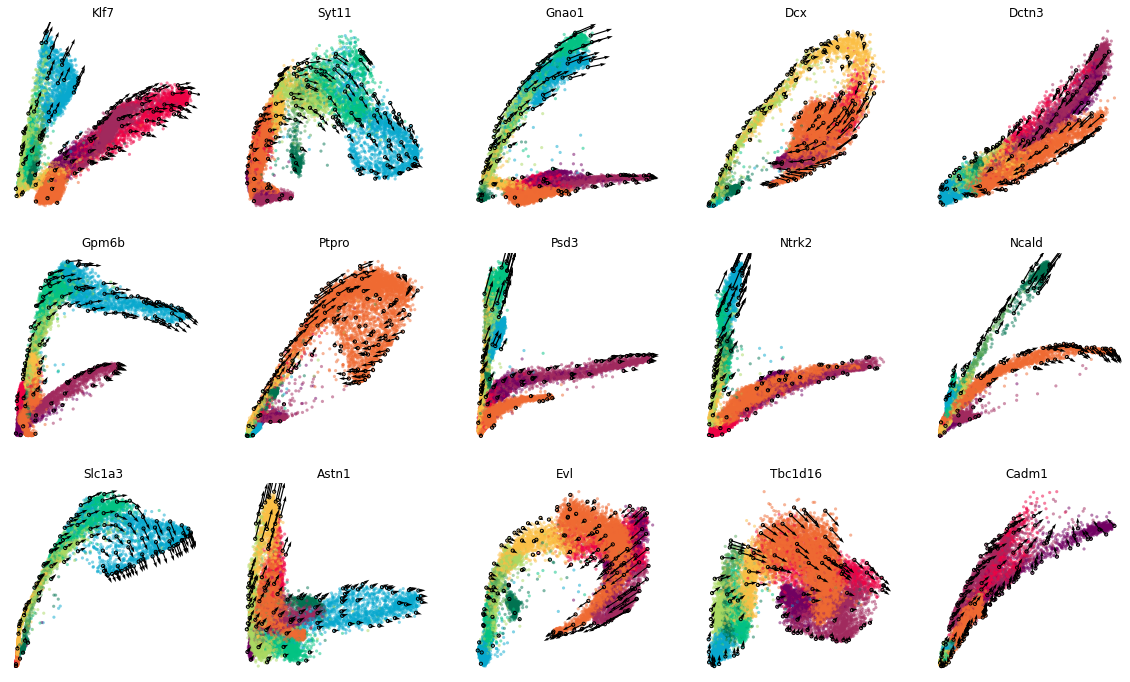

In [182]:
%autoreload 2

# gene_list=list(cellDancer_df[cellDancer_df.gene_name.isin(gene_list)]['gene_name'].drop_duplicates())
gene_list=['Klf7', 'Syt11', 'Gnao1', 'Dcx', 'Dctn3', 'Gpm6b', 'Ptpro', 'Psd3', 'Ntrk2', 'Ncald', 'Slc1a3', 'Astn1', 'Evl','Tbc1d16', 'Cadm1']

ncols=5

height=math.ceil(len(gene_list)/ncols)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.gene.scatter_gene(
        ax=ax,
        x='splice',
        y='unsplice',
        cellDancer_df=cellDancer_df,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_neuro,
        alpha=0.5, 
        s = 10,
        velocity=True,
        gene=gene_list[i])
    
    ax.set_title(gene_list[i])
    ax.axis('off')

plt.savefig('/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/velocyto/neuro/result_detailcsv/test_speed/epoch200check_n10Ratio0.1autoDTrueautoNFalsep3binFalsejob40/cell_dancer_velocity_2022-05-27 18-24-50/storyboard/15_sample_genes_8njob.pdf')
# plt.savefig('/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/velocyto/neuro/result_detailcsv/test_speed/epoch200check_n10Ratio0.1autoDTrueautoNFalsep3binFalsejob40/cell_dancer_velocity_2022-05-27 18-24-50/storyboard/Evl_genes.pdf')


plt.show()

## Load velocity estimation result of 2159 genes

To display the prediction in embedding level and to estimate pseudotime by using all genes, all the 2159 genes have already been predicted and could be downloaded from [Github](link). The csv file could be loaded by ```pd.read_csv()```.

In [127]:
#detail_file = '/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/Gastrulation/velocity_result/result_detailcsv/2000genes_with_bin_and_smooth/combined_detail/combined_detail.csv'
cellDancer_df_file = '/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/velocyto/neuro/result_detailcsv/test_speed/epoch200check_n10Ratio0.1autoDTrueautoNFalsep3binFalsejob40/cell_dancer_velocity_2022-05-27 18-24-50/celldancer_estimation.csv'
cellDancer_df=pd.read_csv(cellDancer_df_file)

## loss

array([[<AxesSubplot:title={'center':'loss'}>]], dtype=object)

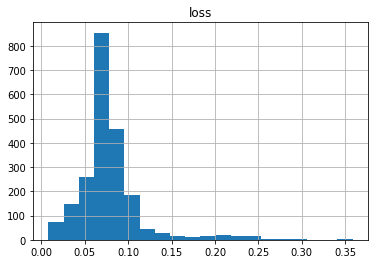

In [131]:
gene_loss=cellDancer_df[['gene_name','loss']].drop_duplicates()


In [132]:
gene_list=['Klf7', 'Syt11', 'Gnao1', 'Dctn3', 'Gpm6b', 'Stxbp6', 'Dcx', 'Psd3', 'Ntrk2', 'Ncald', 'Slc1a3', 'Astn1', 'Camk2a', 'Evl','Tbc1d16', 'Cadm1', 'Kcnip1', 'Ptpro', 'Sez6l', 'Diaph3',]

<AxesSubplot:ylabel='Frequency'>

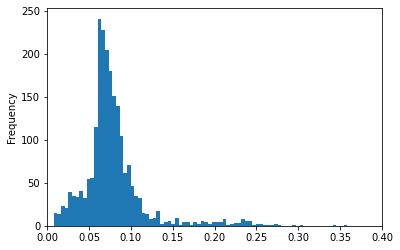

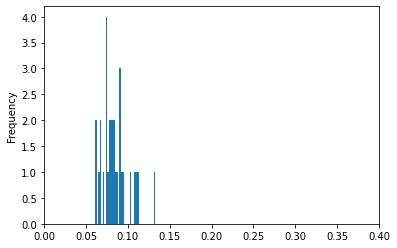

In [164]:
gene_loss_20genes=gene_loss[gene_loss.gene_name.isin(gene_list)]
plt.figure()
gene_loss['loss'].plot.hist(xlim=(0,0.4),bins=80)
plt.figure()
gene_loss_20genes['loss'].plot.hist(xlim=(0,0.4),bins=40)

<AxesSubplot:title={'center':'hist loss'}, ylabel='Density'>

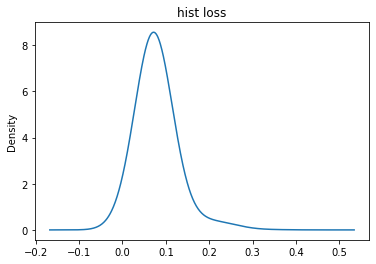

In [152]:
fig, ax = plt.subplots()
gene_loss.loss.plot.kde(ax=ax, legend=False, title='hist loss',bw_method=1)


In [145]:
gene_loss_20genes.sort_values('loss')

,gene_name,loss
30674740,Syt11,0.060929
32996660,Cadm1,0.064899
4408020,Dctn3,0.066869
6385280,Dcx,0.073448
17940460,Evl,0.074870
671180,Klf7,0.077477
2739140,Gnao1,0.078081
38783320,Kcnip1,0.079982
19409800,Ncald,0.081272
37187000,Sez6l,0.082143


cellDancer_df## Compute Cell Velocity

In [155]:
cellDancer_df

,cellIndex,gene_name,unsplice,splice,unsplice_predict,splice_predict,alpha,beta,gamma,loss,cellID,clusters,embedding1,embedding2,index,velocity1,velocity2
0,0,Stom,0.000000,0.006305,9.385150e-07,0.006294,0.000002,0.951817,0.003524,0.068943,10X83_2:AAACGGGGTCTCTTTAx,ImmGranule2,18.931086,-1.862429,0,NaN,NaN
1,1,Stom,0.000000,0.006305,9.385150e-07,0.006294,0.000002,0.951817,0.003524,0.068943,10X83_2:AACCATGGTTCAACCAx,ImmGranule2,18.419891,-1.282895,1,NaN,NaN
2,2,Stom,0.000000,0.008353,9.295276e-07,0.008339,0.000002,0.951943,0.003514,0.068943,10X83_2:AACACGTTCTGAAAGAx,CA2-3-4,2.369887,16.868419,2,NaN,NaN
3,3,Stom,0.000000,0.000000,9.668082e-07,0.000000,0.000002,0.951425,0.003555,0.068943,10X83_2:AAAGATGCATTGAGCTx,CA,-5.351040,10.676485,3,NaN,NaN
4,4,Stom,0.000000,0.000000,9.668082e-07,0.000000,0.000002,0.951425,0.003555,0.068943,10X83_2:AACCATGTCTACTTACx,CA1-Sub,-6.189126,11.754900,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39109835,18135,Prmt8,0.131071,0.262922,1.410238e-01,0.266331,0.095084,0.573575,0.260010,0.109623,10X84_3:TTTCCTCCACCATCCTx,ImmGranule1,10.812611,-2.487668,18135,NaN,NaN
39109836,18136,Prmt8,0.198949,0.531809,2.013258e-01,0.517340,0.117767,0.568054,0.266923,0.109623,10X84_3:TTTGTCACATGAAGTAx,CA2-3-4,8.246204,23.482788,18136,NaN,NaN
39109837,18137,Prmt8,0.173362,0.212177,1.804222e-01,0.234265,0.112805,0.569238,0.256904,0.109623,10X84_3:TTTCCTCCACGGTAAGx,nIPC,-3.441272,-4.917364,18137,NaN,NaN
39109838,18138,Prmt8,0.216978,0.338159,2.186953e-01,0.355581,0.126118,0.565421,0.259761,0.109623,10X84_3:TTTGTCAAGCGTCAAGx,ImmGranule2,16.394199,-6.143549,18138,NaN,NaN


## coumpute cell velocity

For the prediction in the embedding level, if not specified, all genes in cellDancer_df will be used to calculate the prediction in the embedding level. ```celldancer.compute_cell_velocity.compute()```. 

Following the method of [velocyto](link) and [scVelo](link), we project the velocity vectors of the cells into the low-dimensional embedding space. The probabilities of one cell transitioning into another cell are computed. The nearest 200 neighbors in the embedding level (such as PCA, t-SNE, or UMAP) are computed by default. ```speed up``` allows saving time by giving the sampling grid to downsample cells. 

After the calculation, the predicted direction in the embedding level, i.e. columns 'velocity1' and 'velocity2' will be added to the original dataframe and returned.

In [154]:
%autoreload 2

# Set Parameters
# projection_neighbor_choice='embedding'
# expression_scale=None
projection_neighbor_size=200
speed_up=(60,60)

# Compute cell velocity
cellDancer_df=compute(cellDancer_df=cellDancer_df,
              # projection_neighbor_choice=projection_neighbor_choice,
              # expression_scale=expression_scale,
              # projection_neighbor_size=projection_neighbor_size,
              speed_up=speed_up)

```cdplt.cell.scatter_cell()``` could be used to display the predicted direction in embedding level. Considering cell fate predicted by the original RNA velocity model as a benchmark, we first test cell fate inferred by cellDancer. The cell velocity graph shows that cellDancer accurately infers a lineage tree of hippocampus including five major branching lineages corresponding to dentate gyrus granule neurons, pyramidal neurons in subiculum and CA1, pyramidal neurons in CA2/3/4, oligodendrocyte precursors (OPCs), and astrocytes (Fig. 4A). The flowing direction of cell fate predicted by cellDancer is in a good agreement with the results of original RNA velocity model. 

(genes, cells): (2156, 18140)


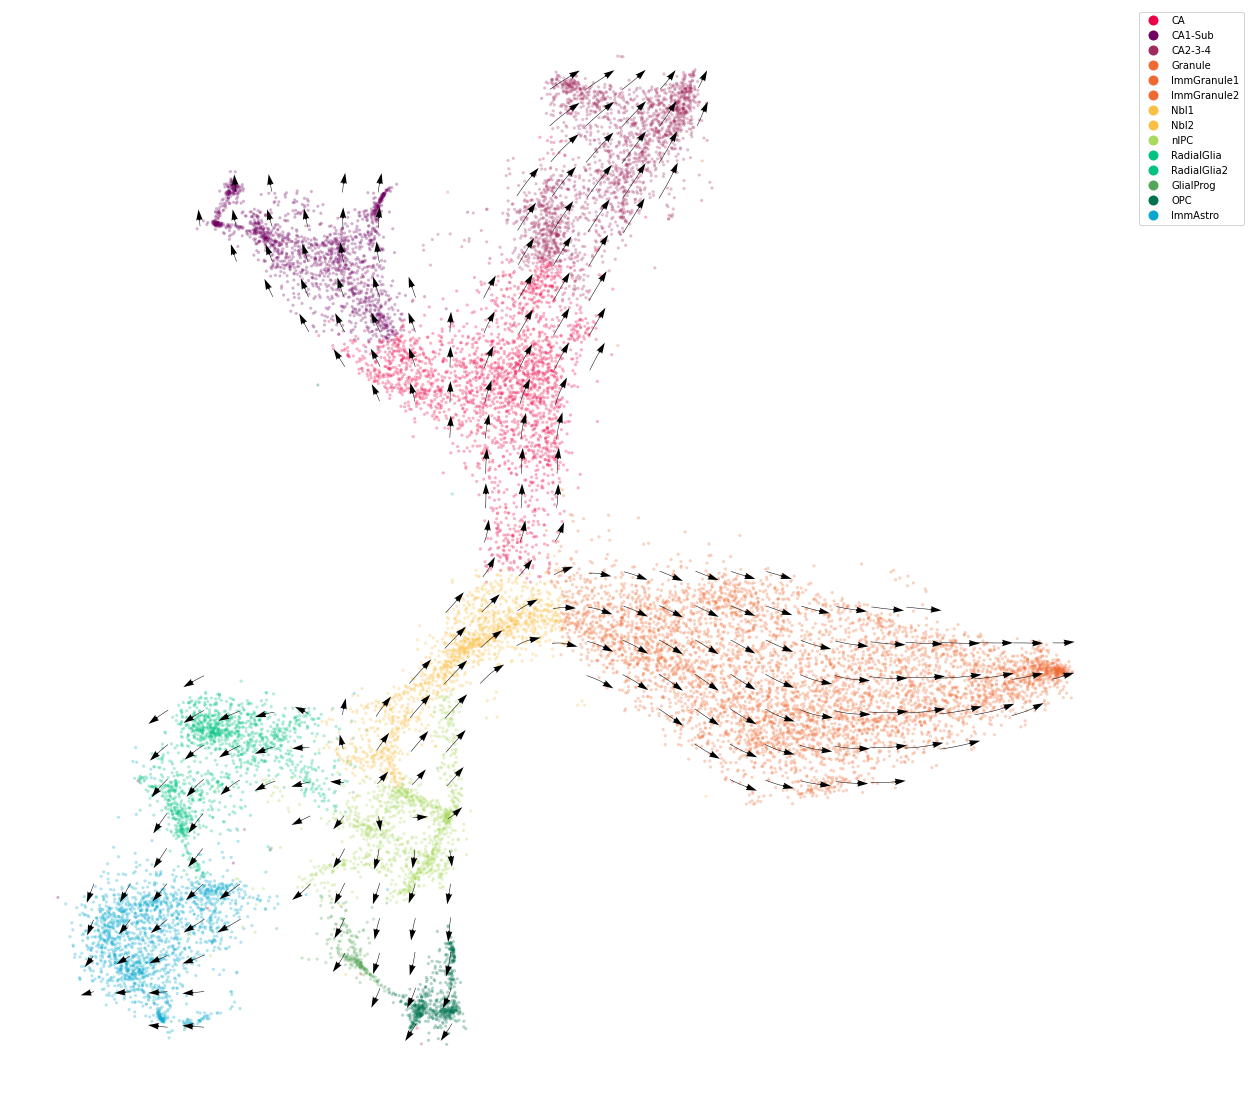

In [154]:
# Plot cell velocity
# Set Parameters
min_mass=2
arrow_grid=(30,30)
alpha_inside=0.3


fig, ax = plt.subplots(figsize=(20,20))
im = cdplt.cell.scatter_cell(ax,cellDancer_df, colors=colormap.colormap_neuro, alpha=alpha_inside, s=10,
             velocity=True, legend='on',min_mass=min_mass,arrow_grid=arrow_grid)
ax.axis('off')
plt.show()

## Estimate Pseudotime

The pseudotime could be estimated

Pseudo random numbers seeds are:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8880/8880 [03:30<00:00, 42.24it/s]


use path_similarity:  0.25
There are 5 clusters.
[0 1 2 3 4]


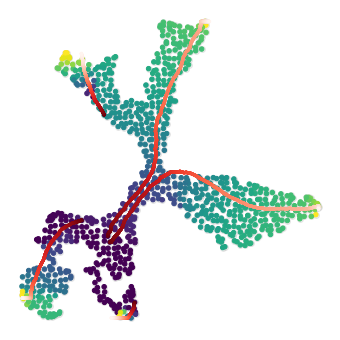




Cluster  0
Total cells in the cluster:  450
MAX allowed zero time cells:  22
MAX allowed terminal cells:  22
Only  1  terminal cells left.
[603]
72  zero cells left.
Sample trajs for zero-time cells in cluster  0   ...
Pseudo random numbers seeds are:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]



Cluster  0
Total cells in the cluster:  72
MAX allowed zero time cells:  22
MAX allowed terminal cells:  22
Only  7  zero cells left. 
[80, 193, 204, 258, 403, 598, 682]
Only  3  terminal cells left.
[666, 748, 870]
number of paths:  2 2

Display reference paths for cluster 0


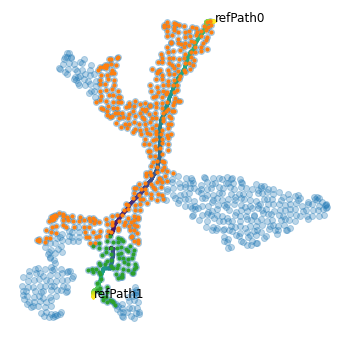


intercluster cell time adjustment
number of cells:  450
Cutoff is  0.05338801800641271
Number of nodes:  2
clusterIDs:  [0, 1]

Consolidating time between clusters  0  and  1 ...
pair_cellIDs:  (90, 102)
pair_cellIDs:  (425, 80)
pair_cellIDs:  (501, 16)
pair_cellIDs:  (343, 204)
pair_cellIDs:  (457, 658)
pair_cellIDs:  (151, 671)
pair_cellIDs:  (391, 709)
pair_cellIDs:  (237, 22)
pair_cellIDs:  (564, 682)
pair_cellIDs:  (643, 818)
pair_cellIDs:  (850, 451)
pair_cellIDs:  (839, 836)
pair_cellIDs:  (842, 802)
pair_cellIDs:  (414, 403)

Peak mode:  most_frequent_shift


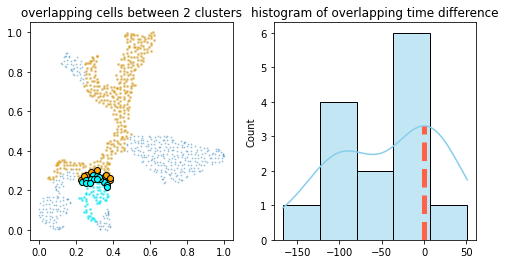

Time shift is:  1
The overlapping cells are: 
cell  425  from cluster  0  and  80  from cluster  1


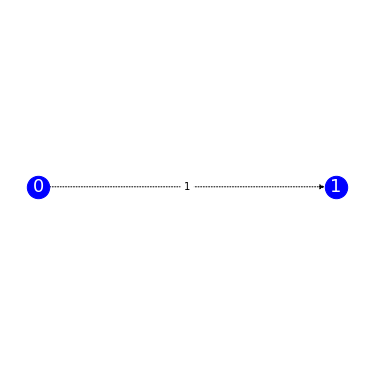

Connected components:  {0, 1}
All nodes adjustment:  {0: 0, 1: 1}



Cluster  1
Total cells in the cluster:  278
MAX allowed zero time cells:  13
MAX allowed terminal cells:  13
Only  0  zero cells left. 
[]
Only  1  terminal cells left.
[599]
number of paths:  1 1

Display reference paths for cluster 1


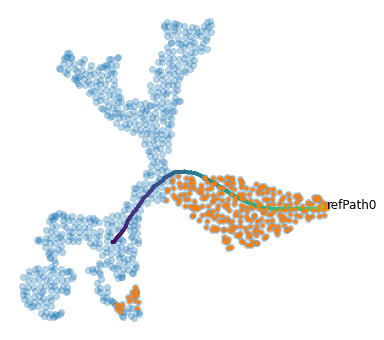




Cluster  2
Total cells in the cluster:  106
MAX allowed zero time cells:  10
MAX allowed terminal cells:  10
Only  0  zero cells left. 
[]
Only  1  terminal cells left.
[742]
number of paths:  1 1

Display reference paths for cluster 2


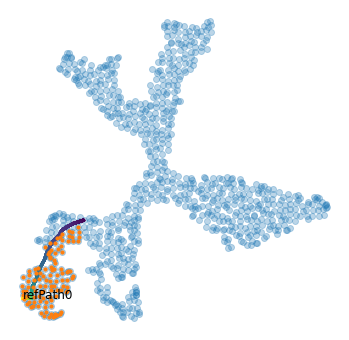




Cluster  3
Total cells in the cluster:  43
MAX allowed zero time cells:  10
MAX allowed terminal cells:  10
Only  0  zero cells left. 
[]
Only  2  terminal cells left.
[230, 649]
number of paths:  1 1

Display reference paths for cluster 3


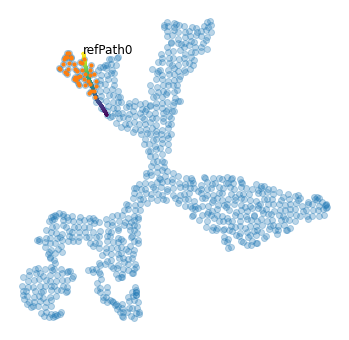




Cluster  4
Total cells in the cluster:  11
MAX allowed zero time cells:  10
MAX allowed terminal cells:  10
Only  0  zero cells left. 
[]
Only  1  terminal cells left.
[849]
number of paths:  1 1

Display reference paths for cluster 4


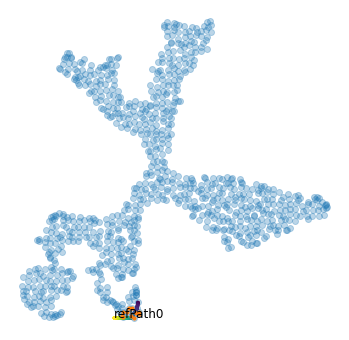




All intra cluster cell time has been resolved.




intercluster cell time adjustment
number of cells:  888
Cutoff is  0.058423757617624104
Number of nodes:  5
clusterIDs:  [0, 1, 2, 3, 4]

Consolidating time between clusters  0  and  1 ...
pair_cellIDs:  (666, 419)
pair_cellIDs:  (857, 540)
pair_cellIDs:  (140, 336)
pair_cellIDs:  (811, 197)
pair_cellIDs:  (716, 72)
pair_cellIDs:  (689, 213)
pair_cellIDs:  (119, 803)
pair_cellIDs:  (60, 668)
pair_cellIDs:  (417, 159)
pair_cellIDs:  (242, 799)
pair_cellIDs:  (310, 329)
pair_cellIDs:  (157, 199)
pair_cellIDs:  (535, 688)
pair_cellIDs:  (130, 187)
pair_cellIDs:  (870, 487)
pair_cellIDs:  (319, 789)

Peak mode:  most_frequent_shift


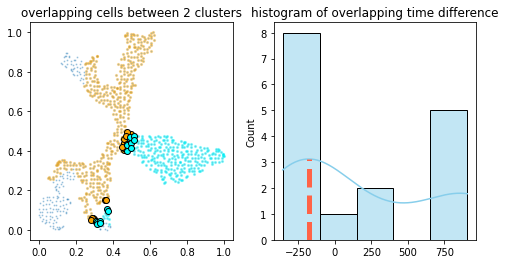

Time shift is:  -180
The overlapping cells are: 
cell  811  from cluster  0  and  197  from cluster  1

Consolidating time between clusters  0  and  2 ...
pair_cellIDs:  (272, 267)
pair_cellIDs:  (662, 288)
pair_cellIDs:  (416, 99)
pair_cellIDs:  (753, 148)
pair_cellIDs:  (203, 569)
pair_cellIDs:  (254, 125)
pair_cellIDs:  (261, 807)
pair_cellIDs:  (868, 856)
pair_cellIDs:  (438, 266)
pair_cellIDs:  (683, 307)
pair_cellIDs:  (884, 132)
pair_cellIDs:  (260, 781)
pair_cellIDs:  (572, 248)
pair_cellIDs:  (118, 13)
pair_cellIDs:  (744, 280)
pair_cellIDs:  (648, 23)
pair_cellIDs:  (734, 325)
pair_cellIDs:  (557, 345)
pair_cellIDs:  (564, 131)

Peak mode:  most_frequent_shift


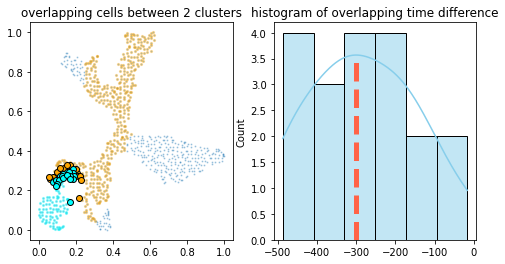

Time shift is:  -308
The overlapping cells are: 
cell  564  from cluster  0  and  131  from cluster  2

Consolidating time between clusters  0  and  3 ...
pair_cellIDs:  (235, 366)
pair_cellIDs:  (295, 139)
pair_cellIDs:  (362, 225)
pair_cellIDs:  (223, 77)
pair_cellIDs:  (160, 296)
pair_cellIDs:  (381, 38)
pair_cellIDs:  (127, 252)
pair_cellIDs:  (354, 196)
pair_cellIDs:  (341, 427)
pair_cellIDs:  (19, 285)
pair_cellIDs:  (384, 184)

Peak mode:  most_frequent_shift


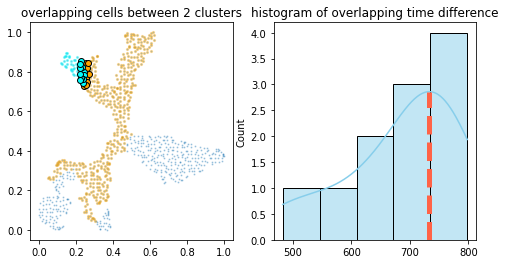

Time shift is:  730
The overlapping cells are: 
cell  341  from cluster  0  and  427  from cluster  3

Consolidating time between clusters  0  and  4 ...
pair_cellIDs:  (666, 657)
pair_cellIDs:  (119, 257)

Peak mode:  least_shift


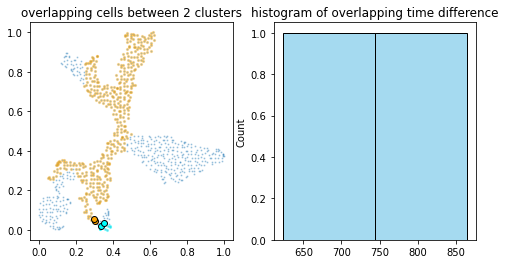

Time shift is:  623
The overlapping cells are: 
cell  666  from cluster  0  and  657  from cluster  4

Consolidating time between clusters  1  and  2 ...
No close cells between clusters	 (1, 2)

Consolidating time between clusters  1  and  3 ...
No close cells between clusters	 (1, 3)

Consolidating time between clusters  1  and  4 ...
pair_cellIDs:  (790, 657)
pair_cellIDs:  (189, 609)
pair_cellIDs:  (487, 463)
pair_cellIDs:  (329, 257)
pair_cellIDs:  (222, 718)
pair_cellIDs:  (668, 849)
pair_cellIDs:  (227, 611)
pair_cellIDs:  (803, 664)
pair_cellIDs:  (717, 732)

Peak mode:  most_frequent_shift


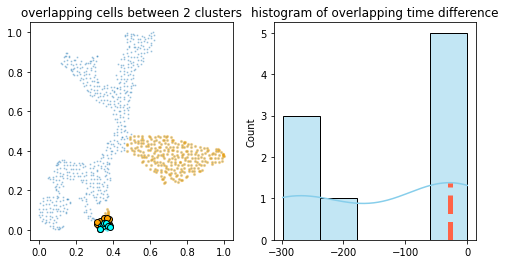

Time shift is:  0
The overlapping cells are: 
cell  329  from cluster  1  and  257  from cluster  4

Consolidating time between clusters  2  and  3 ...
No close cells between clusters	 (2, 3)

Consolidating time between clusters  2  and  4 ...
No close cells between clusters	 (2, 4)

Consolidating time between clusters  3  and  4 ...
No close cells between clusters	 (3, 4)


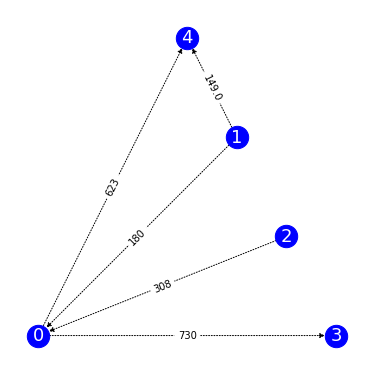

Connected components:  {0, 1, 2, 3, 4}
There are cycle(s), forcing a break.
All nodes adjustment:  {0: -20075, 1: -19452, 2: 0, 3: 0, 4: -19452}


All inter cluster cell time has been resolved.



There are 18140 cells.


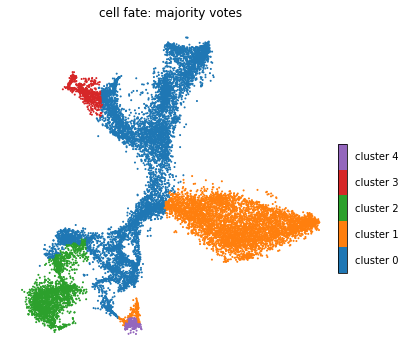

--- 362.36418294906616 seconds ---


In [156]:
%autoreload 2

dt = 0.001
t_total = {0.001: 10000}
n_repeats = 10

speed_up=(60,60)
grid = (30, 30)
load_cellDancer = pseudo_time(
    cellDancer_df=cellDancer_df, 
    grid=grid, 
    dt=dt, 
    t_total=t_total[dt], 
    n_repeats=n_repeats, 
    speed_up=speed_up,
    n_paths = 5,
    psrng_seeds_diffusion=[i for i in range(n_repeats)],
    activate_umap_paths_divider=False,
    n_jobs=12)

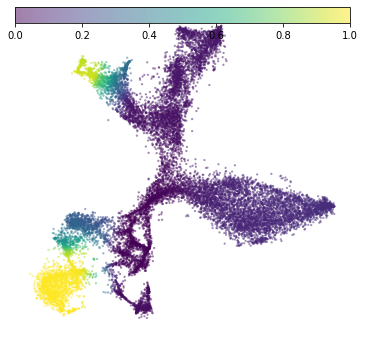

In [157]:
## Plot Pseudotime
fig, ax = plt.subplots(figsize=(6,6))
im=cdplt.cell.scatter_cell(ax,cellDancer_df, colors='pseudotime', alpha=0.5, 
             velocity=False)
ax.axis('off')
plt.show()

## Gene Pseudotime

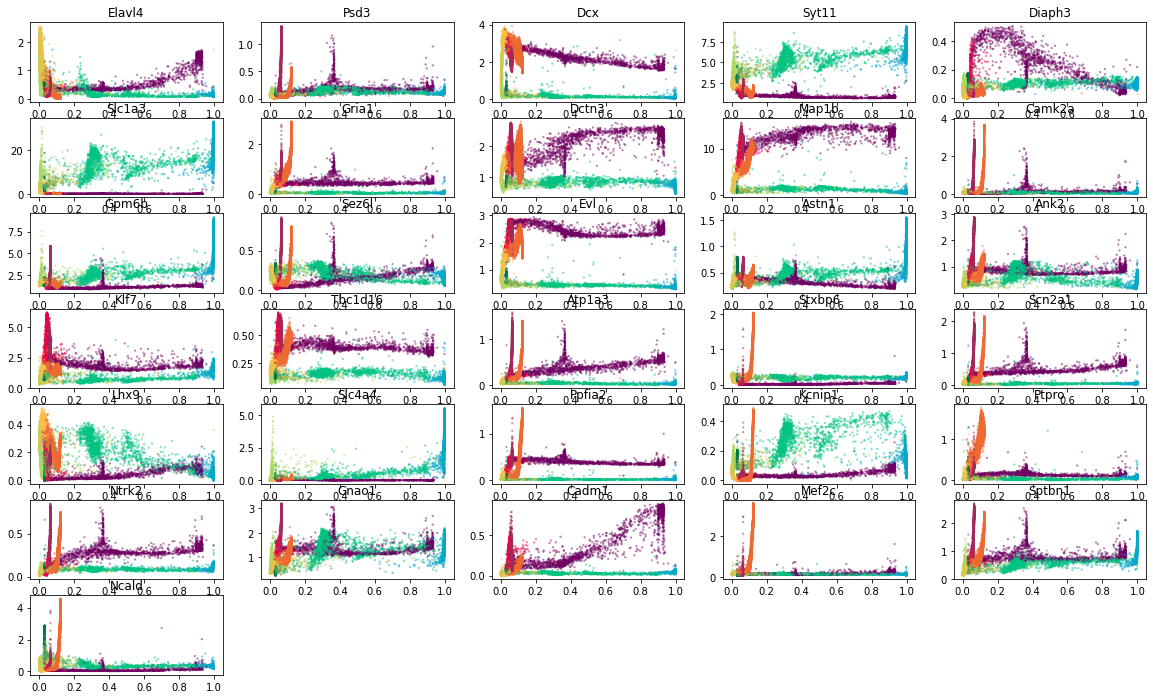

In [161]:
gene_list=['Elavl4','Psd3', 'Dcx', 'Syt11', 'Diaph3', 'Slc1a3', 'Gria1', 'Dctn3', 'Map1b', 'Camk2a', 'Gpm6b', 'Sez6l', 'Evl', 'Astn1', 'Ank2', 'Klf7', 'Tbc1d16', 'Atp1a3', 'Stxbp6', 'Scn2a1', 'Lhx9', 'Slc4a4', 'Ppfia2', 'Kcnip1', 'Ptpro', 'Ntrk2', 'Gnao1', 'Cadm1', 'Mef2c', 'Sptbn1', 'Ncald']


ncols=5
fig = plt.figure(figsize=(20,12))
for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.gene.scatter_gene(
        ax=ax,
        x='pseudotime',
        y='splice',
        cellDancer_df=cellDancer_df,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_neuro,
        alpha=0.5, 
        s = 5,
        velocity=False,
        gene=gene_list[i])

    ax.set_title(gene_list[i])
    # ax.axis('off')

## Gene Parameter in Cell Level

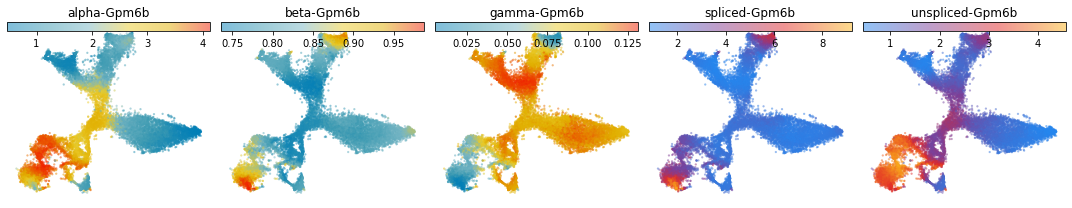

In [162]:
gene_samples=['Gpm6b']
for gene in gene_samples:
    fig, ax = plt.subplots(ncols=5, figsize=(15,3))
    cdplt.cell.scatter_cell(ax[0],cellDancer_df, colors='alpha', 
                 gene=gene, velocity=False)
    cdplt.cell.scatter_cell(ax[1],cellDancer_df, colors='beta', 
                 gene=gene, velocity=False)
    cdplt.cell.scatter_cell(ax[2],cellDancer_df, colors='gamma', 
                 gene=gene, velocity=False)
    cdplt.cell.scatter_cell(ax[3],cellDancer_df, colors='splice', 
                 gene=gene, velocity=False)
    cdplt.cell.scatter_cell(ax[4],cellDancer_df, colors='unsplice', 
                 gene=gene, velocity=False)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[3].axis('off')
    ax[4].axis('off')
    ax[0].set_title('alpha-'+gene)
    ax[1].set_title('beta-'+gene)
    ax[2].set_title('gamma-'+gene)
    ax[3].set_title('spliced-'+gene)
    ax[4].set_title('unspliced-'+gene)
    plt.tight_layout()
    plt.show()

## UMAP using alpha, beta, and gamma

In [31]:
cellDancer_df=embedding(cellDancer_df,'alpha')
cellDancer_df=embedding(cellDancer_df,'beta')
cellDancer_df=embedding(cellDancer_df,'gamma')
cellDancer_df=embedding(cellDancer_df,'alpha_beta_gamma')

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


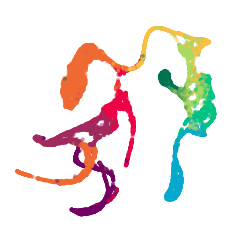

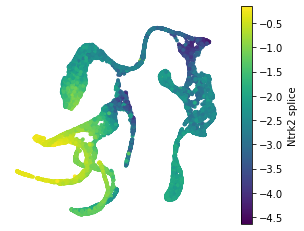

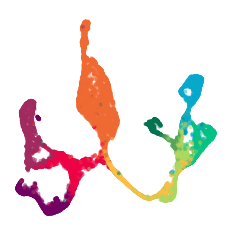

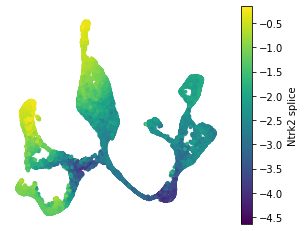

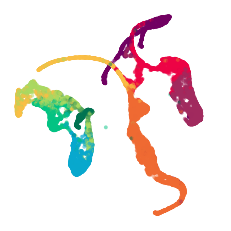

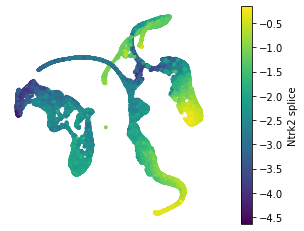

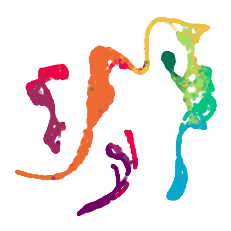

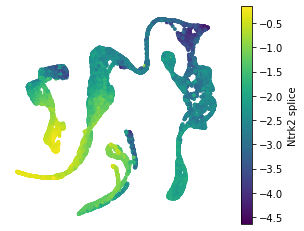

In [35]:
cdplt.cell.plot_kinetic_para('alpha',cellDancer_df,color_map=cdplt.colormap.colormap_neuro, save_path=None,title=None)
cdplt.cell.plot_kinetic_para('alpha',cellDancer_df,gene='Ntrk2',color_map=cdplt.colormap.colormap_neuro ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('beta',cellDancer_df,color_map=cdplt.colormap.colormap_neuro ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('beta',cellDancer_df,gene='Ntrk2',color_map=cdplt.colormap.colormap_neuro ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('gamma',cellDancer_df,color_map=cdplt.colormap.colormap_neuro,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('gamma',cellDancer_df,gene='Ntrk2',color_map=cdplt.colormap.colormap_neuro ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('alpha_beta_gamma',cellDancer_df,color_map=cdplt.colormap.colormap_neuro ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('alpha_beta_gamma',cellDancer_df,gene='Ntrk2',color_map=cdplt.colormap.colormap_neuro ,save_path=None,title=None)